## Abstract

In this blog post, the design process, and the impact of the decisions made in that design process, of Automated Decision models were explored. Through a data set of credit applicants and their eventual repayment status, a model for maximizing the profits of a loan issuing bank/individual was created. The process of feature optimization and weighting, followed by decision threshold optimization allowed us to maximize the profits we received from the issuance of loans. This raised fascinating questions regarding fairness and prioritization when it comes to Automated Decisions. My model optimized for profits, resulting in a willingness to risk giving some loans that would default if it meant more that would be repaid. 



## Set Up The Data



In [10]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

X_train = df_train.drop(columns = ["loan_status", "loan_grade"])
y_train = df_train["loan_status"]

df_train.head()



,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train["loan_status"])

def prepare_data(df):
  df = df.dropna()
  y = le.transform(df["loan_status"])
  df = df.drop(["loan_status"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(df_train)

### Exploring the Data

Create at least two visualizations and one summary table in which you explore patterns in the data. You might consider some questions like:

1. How does loan intent vary with the age, length of employment, or homeownership status of an individual?
2. Which segments of prospective borrowers are offered low interest rates? Which segments are offered high interest rates?
3. Which segments of prospective borrowers have access to large lines of credit?

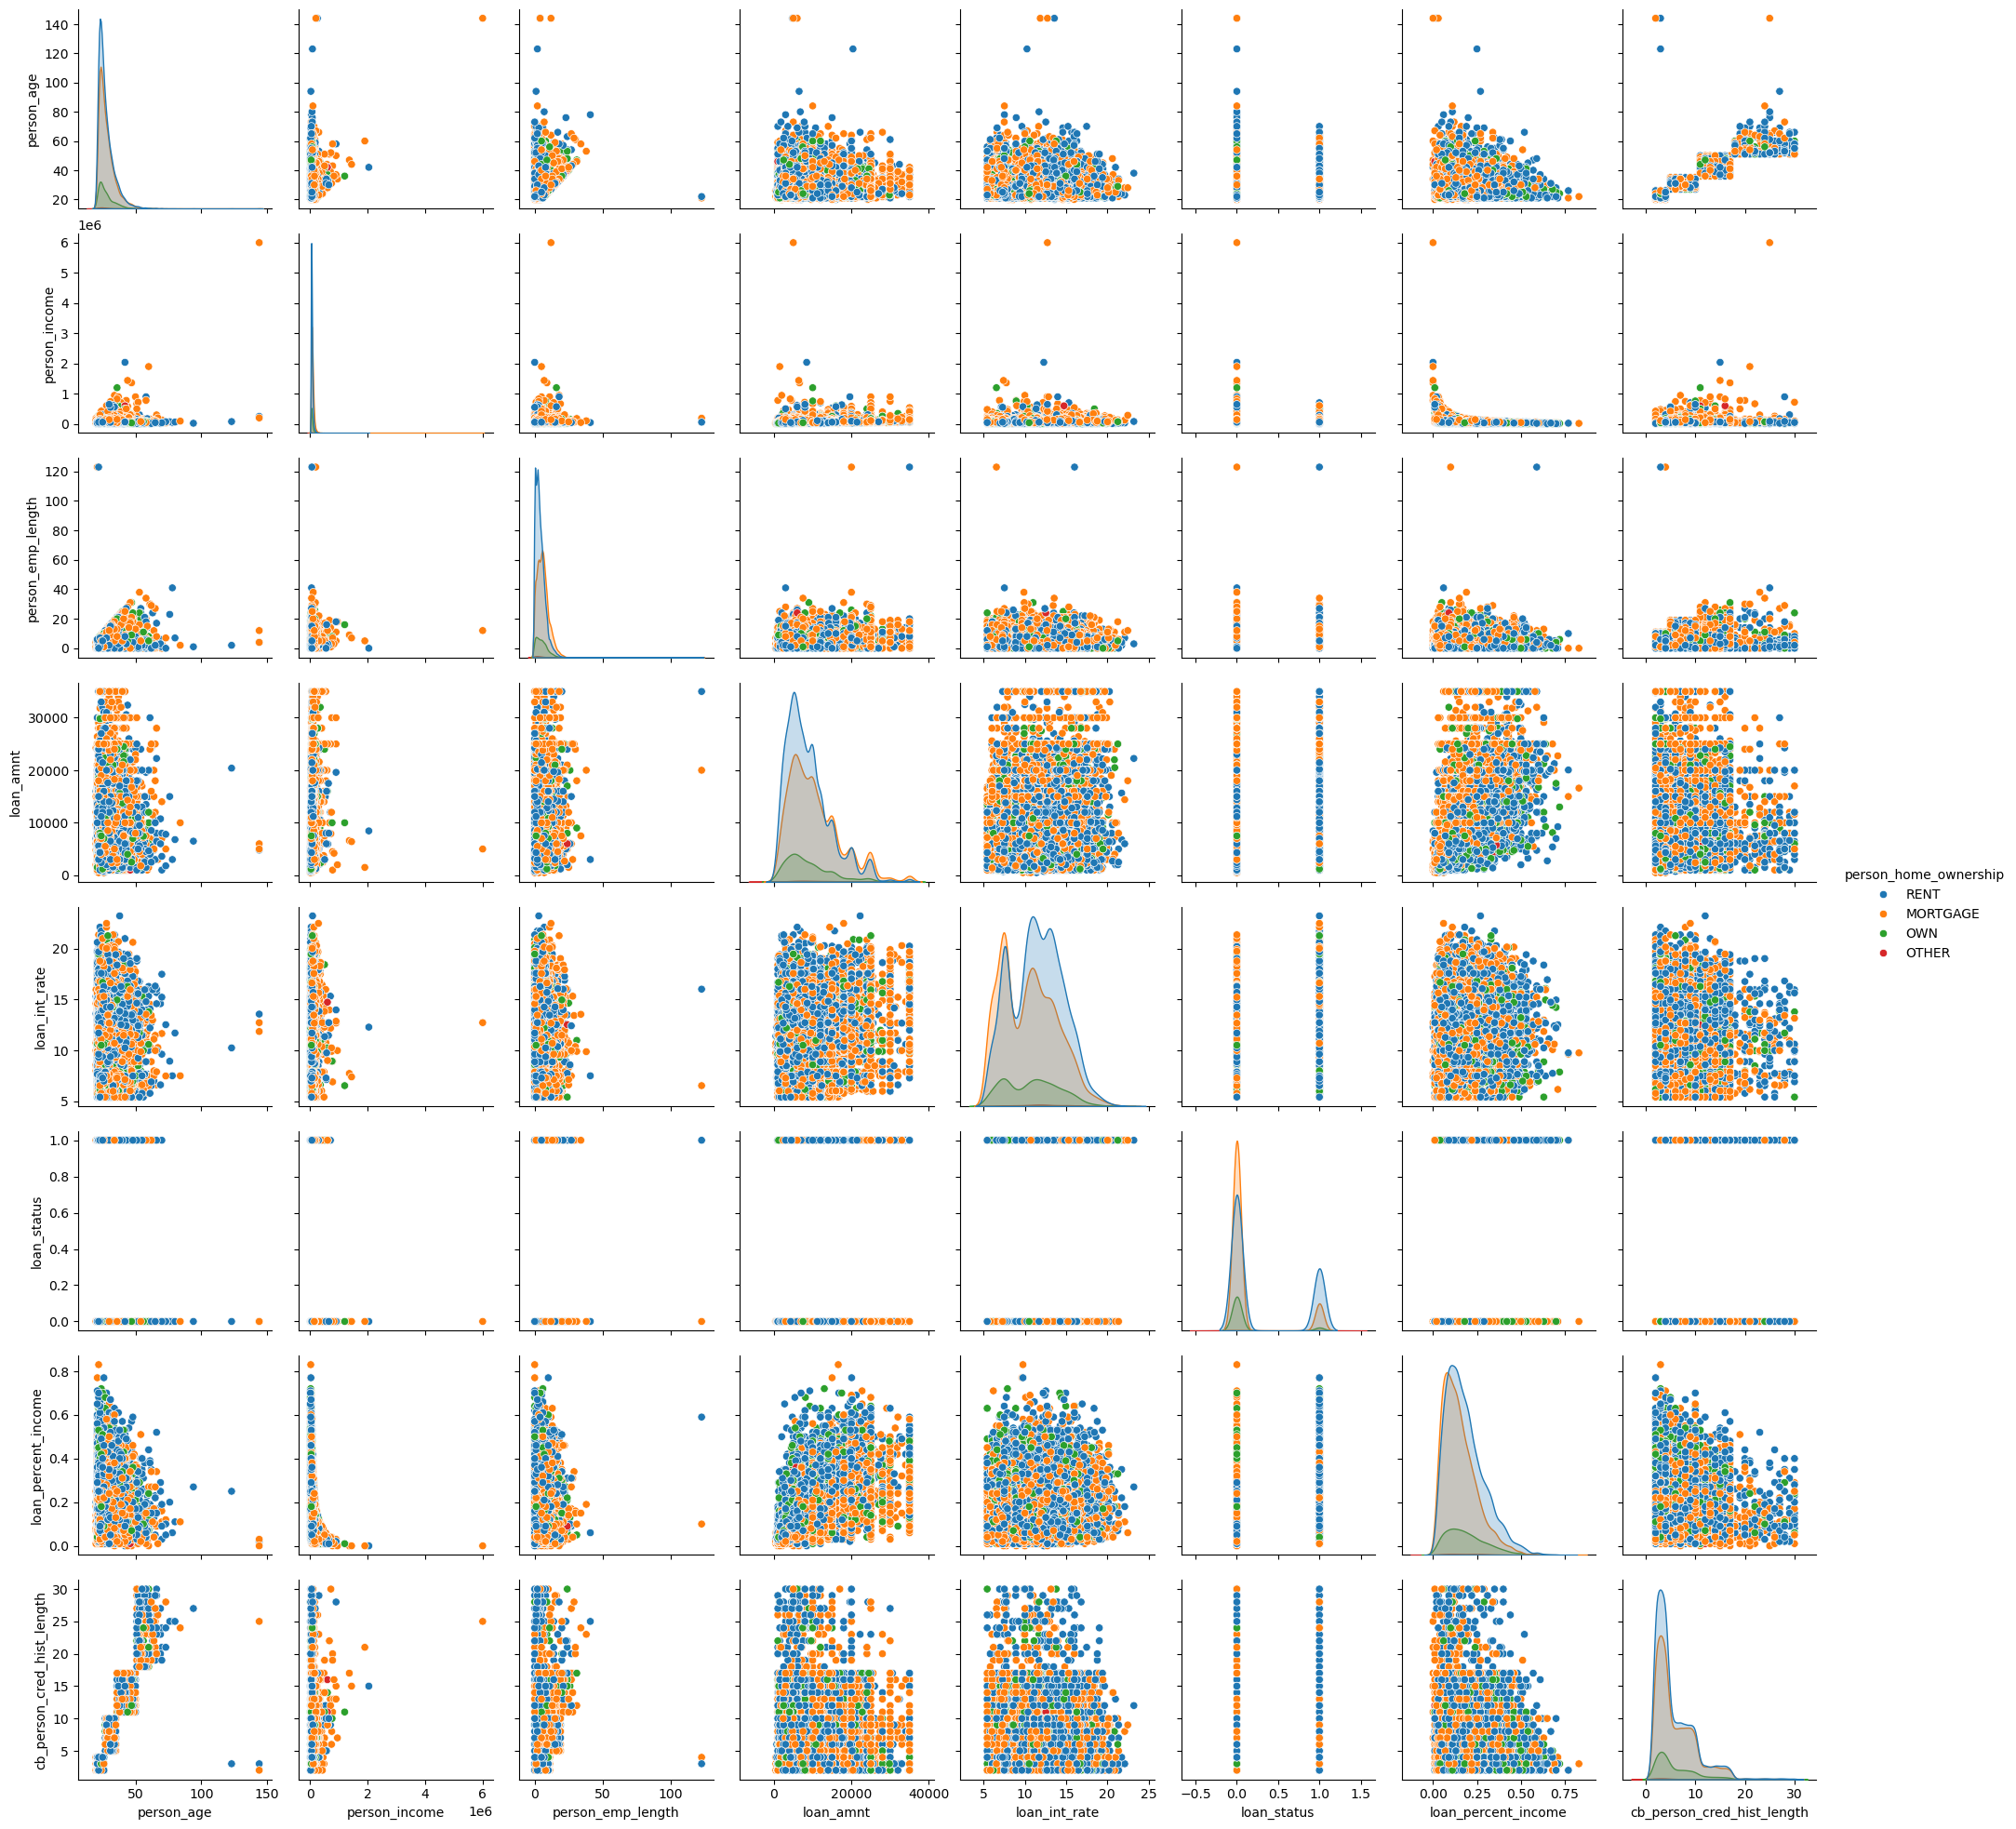

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.pairplot(df_train, hue="person_home_ownership")
plt.show()

It seems to me that the most striking differentiator among variables is a persons income. Individuals with high incomes seem to be much less likely to default, which could mean that our model will rely on this quite a bit as an indicator of repayment.

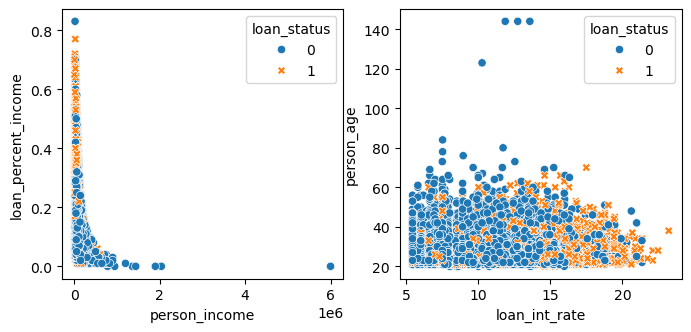

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

p1 = sns.scatterplot(df_train, x = "person_income", y = "loan_percent_income", ax = ax[0],  style = "loan_status", hue = "loan_status")

# sns.despine() # remove the top and right spines

# p1.title.set_text()


p2 = sns.scatterplot(df_train, x = "loan_int_rate", y = "person_age", ax = ax[1],  style = "loan_status", hue = "loan_status")

Income, Interest rate, and loan percent of income seem to be highly correlated with loan status. This is potentially problematic because it means people with the fewest resources will most likely be the ones given the most restricted and expensive capital due to their associated risk.

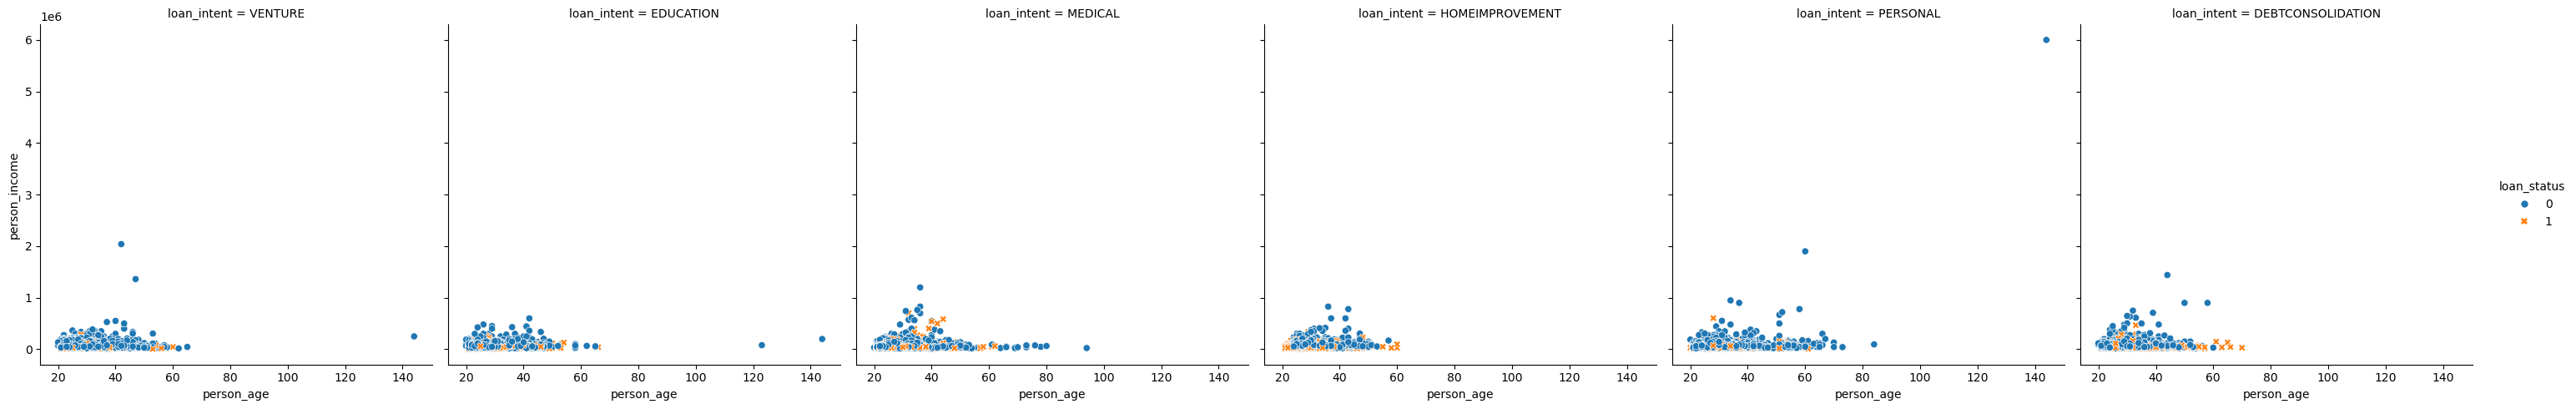

In [14]:
g = sns.relplot(data=df_train, x="person_age", y="person_income", col="loan_intent", hue="loan_status", style="loan_status", kind="scatter")


Educational loans seem to be much more concentrated at the younger end of the spectrum  compared to the other categories, while medical loans seem to span a much wider range. 

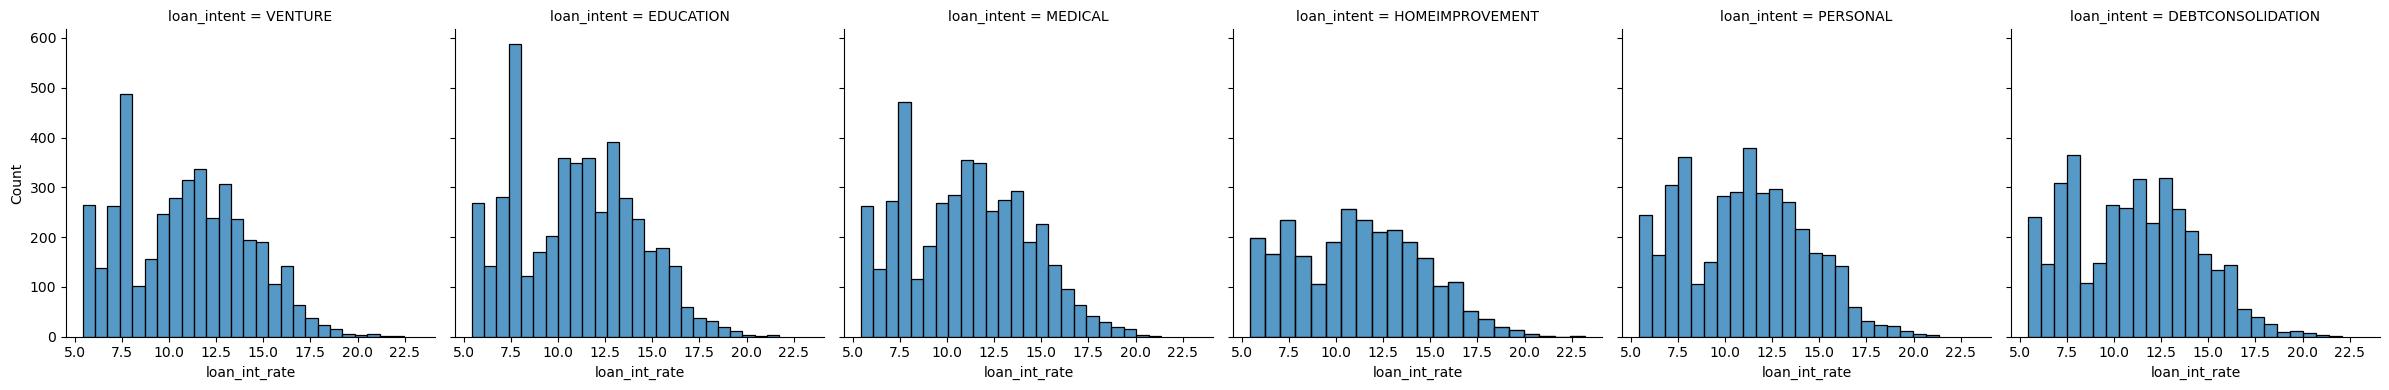

In [15]:
g = sns.FacetGrid(df_train, col="loan_intent", height=4, aspect=1)
g.map(sns.histplot, "loan_int_rate")

While none of the differences in the distributions of interest rates on loans by category are strikingly different, what is interesting to me is that they all seem to have a sort of bimodal distribution. There seems to be another factor influencing if the groups receive a low or high interest rate loans. My hypothesis would be that individuals who make a lot of money are given loans much cheaper than those who do not. 

In [16]:
df_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


### Fitting the Model

In [17]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression



all_qual_cols = ["loan_intent", "person_home_ownership", "cb_person_default_on_file"]
all_quant_cols = ['person_emp_length', 'loan_amnt', 'loan_int_rate', "loan_percent_income", "cb_person_cred_hist_length"]
best_score = 0
best_cols = []

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 4):
    cols = qual_cols + list(pair) 
    LR = LogisticRegression(max_iter = 10000)
    LR.fit(X_train[cols], y_train)
    new_score = LR.score(X_train[cols], y_train)
    if new_score > best_score:
      best_score = new_score
      best_cols = cols  




print("Highest Scoring Columns: ", best_cols)
print("Highest Score: ", best_score)

Highest Scoring Columns:  ['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Highest Score:  0.8461605622735409


In [18]:
LR = LogisticRegression(max_iter = 10000)
LR.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [19]:
from sklearn.feature_selection import RFECV

selector = RFECV(LR, step = 1, cv = 5)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]
print("Selected features:", selected_features)

Selected features: Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'cb_person_cred_hist_length',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_D', 'cb_person_default_on_file_N',
       'cb_person_default_on_file_Y'],
      dtype='object')


/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [20]:
LR.fit(X_train[selected_features], y_train)

LogisticRegression(max_iter=10000)

Now that we have fit a mode, we can extract the weights, and use it to score each training loan. The resulting score can then be used to determine the best thresshold for making a decision in order to maximize our profits by giving a loan or not.




1.5223252366858058


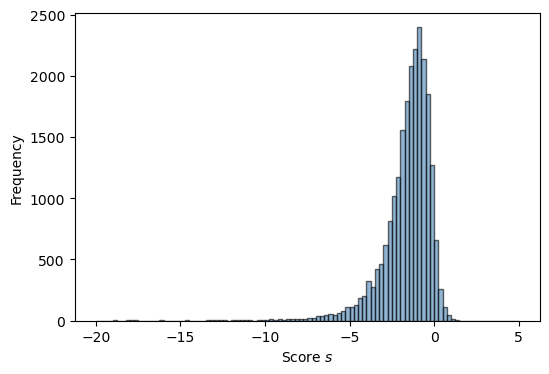

In [21]:
import numpy as np
w = LR.coef_.reshape(-1)
X = X_train[selected_features]
s = X@w

print(s.max())

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(s, bins = 100, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black", range=[-20, 5])
labs = ax.set(xlabel = r"Score $s$", ylabel = "Frequency")

With these scores calculated, we are going to use the following simplified formula's to determine the total profit made at each potential threshold:


##### Profit on a loan repaid in full:

loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt

##### Borrower Defaults on a Loan

loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt

##### Calculate Optimal Threshold

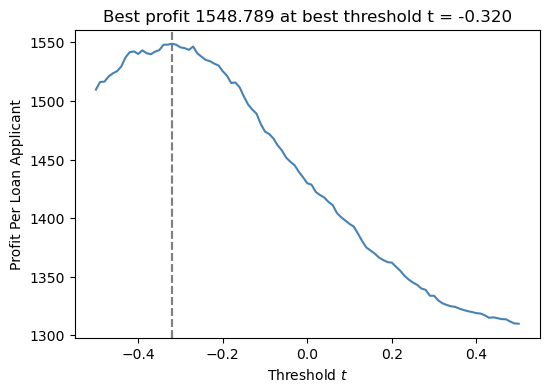

In [22]:


best_profit = float('-inf')
best_threshold = -20

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
profits = []
thresholds = np.linspace(-.5, 0.5, 101)

loan_amnt = X_train['loan_amnt']  
loan_int_rate = X_train['loan_int_rate'] 

for t in np.linspace(-.5, 0.5, 101): 
    y_pred = s > t
    acc = (y_pred == y_train)
    profit_repaid = ((acc &  -(y_train+1)) * (loan_amnt * (1 + 0.25 * (loan_int_rate/100))**10 - loan_amnt))
    loss_default = ((-(acc+1) & y_train) * (loan_amnt * (1 + 0.25 * (loan_int_rate/100))**3 - .7 * loan_amnt))
    profit = (profit_repaid - loss_default).mean()
    profits.append(profit)
    if profit > best_profit: 
        best_profit = profit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
ax.plot(thresholds, profits, color="steelblue")
ax.axvline(best_threshold, linestyle="--", color="grey", zorder=-10)

labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Profit Per Loan Applicant", title = f"Best profit {best_profit:.3f} at best threshold t = {best_threshold:.3f}")

The optimal threshold with our model is a score of -0.320. This results in a profit per analyzed grant of $1548.789.

### Testing our Model, Weights, and Threshold



Now let's download the test data and prepare it.

In [23]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

X_test, y_test = prepare_data(df_test)

In [24]:
test_pred = X_test[selected_features]@w

test_pred = test_pred > best_threshold



With our decisions made, we can now figure out how much money we have made on our test loans:

In [25]:
loan_amnt = X_test['loan_amnt']  
loan_int_rate = X_test['loan_int_rate'] 
acc = (test_pred == y_test)
profit_repaid = ((acc &  -(y_test+1)) * (loan_amnt * (1 + 0.25 * (loan_int_rate/100))**10 - loan_amnt))
loss_default = ((-(acc+1) & y_test) * (loan_amnt * (1 + 0.25 * (loan_int_rate/100))**3 - .7 * loan_amnt))

profit = profit_repaid - loss_default

profit.mean()

1496.914919368003

With our algorithm we made $1496.91 per loan analyzed! While this is slightly lower than the $1548 per loan analyzed on our training data, this seems pretty good.

It is important to note that since our goal was profit, this does not mean that we have maximized for reducing defaults on loans


In [26]:
profit.sum()

8578819.402898025

This would have resulted in $8.58 Billion dollars in total profit from the test data loans.

### Impact from the Borrowers Perspective

In [27]:
df_pred = df_test.copy()
df_pred["pred_loan_status"] = (test_pred)

df_pred

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,pred_loan_status
0,21,42000,RENT,5.0,VENTURE,D,1000,15.58,1,0.02,N,4,False
1,32,51000,MORTGAGE,2.0,DEBTCONSOLIDATION,B,15000,11.36,0,0.29,N,9,False
2,35,54084,RENT,2.0,DEBTCONSOLIDATION,C,3000,12.61,0,0.06,N,6,False
3,28,66300,MORTGAGE,11.0,MEDICAL,D,12000,14.11,1,0.15,N,6,False
4,22,70550,RENT,0.0,MEDICAL,E,7000,15.88,1,0.08,N,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6512,26,26000,MORTGAGE,4.0,HOMEIMPROVEMENT,B,12000,NaN,0,0.46,N,3,NaN
6513,27,44640,RENT,0.0,MEDICAL,B,12800,11.83,0,0.29,N,9,False
6514,24,48000,OWN,5.0,VENTURE,A,10400,7.37,0,0.22,N,3,False
6515,26,65000,MORTGAGE,6.0,EDUCATION,A,6000,9.07,0,0.09,N,3,False


#### Age 

In [28]:
bins = [0, 30, 40, 50, 60, 70, 80]

df_pred['age_group'] = pd.cut(df_pred['person_age'], bins, labels=["0-30", "31-40", "41-50", "51-60", "61-70", "71+"], right=False)

df_pred.groupby(["age_group", "loan_status"])["pred_loan_status"].agg(["mean", "count"]).reset_index()

,age_group,loan_status,mean,count
0,0-30,0,0.055729,3194
1,0-30,1,0.414995,947
2,31-40,0,0.050296,1014
3,31-40,1,0.388462,260
4,41-50,0,0.033654,208
5,41-50,1,0.384615,52
6,51-60,0,0.000000,31
7,51-60,1,0.363636,11
8,61-70,0,0.000000,6
9,61-70,1,0.500000,6


This demonstrates a trend that will repeat itself over the course of our entire analysis: our model makes it too easy for people who shouldn't receive a loan to receive one. The false negative rates (people being denied a loan who deserve one) are incredibly low — below 6% in every category. The problem is that especially for younger individuals, our model is highly likely to issue a loan to someone who will default; our model only denies 42% of individuals who go on to default in the 0-30 category, 39% in the 31-40 category, 38% in the 41-50 category, 36% in the 51-60 category, and 50% in the 51-60 category. This is incredibly concerning because young individuals who are given a loan and deffault might not have the financial resources built up to overcome this challenge. 

#### Loan Intent


##### Positive Prediction Rates


In [29]:
df_pred.groupby("loan_intent")["pred_loan_status", "loan_status"].agg(["mean", "count"])

/var/folders/kn/65gyjdg54k7d_hx68jbshfz40000gn/T/ipykernel_89662/3005163201.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pred.groupby("loan_intent")["pred_loan_status", "loan_status"].agg(["mean", "count"])


pred_loan_status       loan_status      
                              mean count        mean count
loan_intent                                               
DEBTCONSOLIDATION         0.136062   904    0.279497  1034
EDUCATION                 0.142857  1176    0.167421  1326
HOMEIMPROVEMENT           0.086039   616    0.246088   703
MEDICAL                   0.152842  1073    0.281553  1236
PERSONAL                  0.135271   998    0.219227  1113
VENTURE                   0.118257   964    0.145701  1105

One thing stands out from simply showing the percent of the time our model predicts a default compared to the percent of the time a default actually occurs: 1, Our model under predicts defaults significantly due to its aim of profit as opposed to actual accuracy. Education and Venture loans seem to be the two categories in which the ratios are similar. This tells us nothing about the accuracy of the Loans, only the rates at which it predicts defaults in each category. While this means that it is easier to get a loan across the board than it should be, this does not necessarily mean it is better for the borrower. Banks probably have a much better sense for if an individual is going to default or not compared to the experience of an individual taking out a loan for the first time. The fact that the bank is abusing that power to prioritize profits could mean that many individuals are put into a financial hole due to unpayable debt. 


##### Error-Rate Balance
Let's see how this breaks down in terms of actual accuracy:

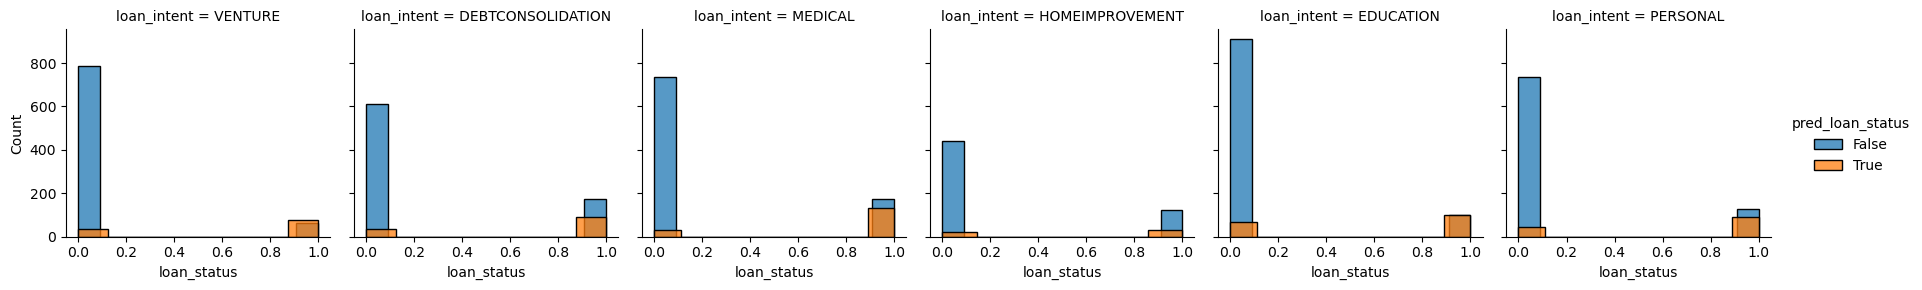

In [30]:
p1 = sns.FacetGrid(df_pred, col="loan_intent", hue="pred_loan_status")
p1.map(sns.histplot, "loan_status")
p1.add_legend()

While not the typical way, these visualizations show the TP and FP across categories. It is clear from these graphs that across the board, our model is pretty good at giving loans to people who deserve them, with only a few people being denied loans who would go on to pay back in full. On the other hand, our model is almost as likely to give a loan than not, if not more likely to give a loan than not, to people who would go on to default. This gun-ho model could be potentially predatory to borrowers, and strictly maximizing for profits could be a really bad idea (Think 2008 Financial Crisis). 

In [31]:
df_pred.groupby(["loan_intent", "loan_status"])["pred_loan_status"].agg(["mean", "count"]).reset_index()

,loan_intent,loan_status,mean,count
0,DEBTCONSOLIDATION,0,0.054348,644
1,DEBTCONSOLIDATION,1,0.338462,260
2,EDUCATION,0,0.070480,979
3,EDUCATION,1,0.502538,197
4,HOMEIMPROVEMENT,0,0.045455,462
5,HOMEIMPROVEMENT,1,0.207792,154
6,MEDICAL,0,0.040365,768
7,MEDICAL,1,0.436066,305
8,PERSONAL,0,0.055270,778
9,PERSONAL,1,0.418182,220


This Quantitative look at error rates reaffirms what we saw from the visualizations: our model has a very high True Negative Rate across categories, and also quite Low True Positive Rates ranging from .207 (Home Improvement) to .546 (Venture). Regardless of category, this means that our model is far from optimized for not issuing loans to people who have a high risk of default, it is optimized to give as many loans to people who will pay back as possible. As mentioned above this could have devastating impacts an individuals financial health. 

#### By Income Level

In [32]:
bins = [0, 50000, 100000, 150000, 200000, 10000000]

df_pred['income_group'] = pd.cut(df_pred['person_income'], bins, labels=["0-50K", "50-100K", "100-150K", "150-200K", "200K+"], right=False)

df_pred.groupby(["income_group", "loan_status"])["pred_loan_status"].agg(["mean", "count"]).reset_index()

,income_group,loan_status,mean,count
0,0-50K,0,0.119768,1553
1,0-50K,1,0.543837,787
2,50-100K,0,0.023223,2153
3,50-100K,1,0.229064,406
4,100-150K,0,0.000000,530
5,100-150K,1,0.000000,61
6,150-200K,0,0.000000,124
7,150-200K,1,0.000000,12
8,200K+,0,0.000000,94
9,200K+,1,0.000000,11


It is fascinating to see that our income variable is an incredibly high predictor of if an individual will receive a loan or not. While not surprising, it seems that if an individual makes over 100K they will receive a loan. 0 Individuals over this income were denied even though many would have defaulted. Even for individuals with an income between 0 and 50 k, our model only rejected 54% of individuals who went on to default. That number is 23% for 50-100K earners, and 0 for everyone with a higher income.


### Discussion

Through this blog post, I learned quite a bit about how different interests can lead to problematic results in a model. I also learned technical skills such as threshold optimization, and the importance of defining and exploring what occurs when you decide on what you are going to optimize for. In our model we optimized for profits, not fairness in any respect. This meant is was more difficult for people in particular groups—medical debt and young— to get a loan. People with medical expenses have higher default rates, and so it is harder for them to get a loan. In my opinion, and at this point we are in the realm of value judgement not fact, the lower availability of credit is not unfair. While I do not have a good definition of fairness, what comes to my mind is that two private* parties involved in a decision act with good faith towards one another and treat each other and everyone else as of equal value. This does not mean that one group should be forced to take unnecessary risk to overcome an existing unfairness. That sort of redistributive action is what governments are responsible for. I do not mean that private individuals can't or shouldn't try to actively overcome existing unfairness, I mean that they cannot be forced to or expected to just because something is unfair. In the case of Medical Debt, the unfair part is the fact that our medical system is so broken that medical expenses become crippling and un-creditable. There is no reason that banks or private creditors should shoulder this unfairness by giving loans that will not be paid back. The money that banks loan should not be thrown around without foresight, because that is the money of everyone else being held and safeguarded. 
Given the willingness of my model to predict repayment, a more relevant discussion is that our model was too willing to give loans to people who probably should not have been given them. Our model found a threshold where giving loans to people with a certain amount of risk meant that enough would repay such that profit would be made in-spite of the fact that a significant portion would default. This is predatory in nature and potentially catastrophic for the individual. This is especially concerning given the banks privilege knowledge of credit, while the borrower could potentially be much less informed regarding their decision. 